## Imports

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import json
from datetime import datetime
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

from keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, Input
from tensorflow import feature_column
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

In [2]:
def read_json(filename):
    if filename.endswith('.json'):
        filename = filename[:-5]
    with open(filename+'.json') as f:
        data = json.load(f)
    return data
             
def write_json(filename, variable):
    if filename.endswith('.json'):
        filename = filename[:-5]
    with open(filename+'.json', 'w') as fp:
        json.dump(variable, fp)

In [3]:
mean_density = read_json('mean_weight.json')
mean_weight = read_json('mean_weight.json')

### Loading data

In [4]:
raw_data = pd.read_csv('7342422066d511eb/dataset/train.csv')

In [5]:
raw_data.isna().sum()

Customer Id                 0
Artist Name                 0
Artist Reputation         750
Height                    375
Width                     584
Weight                    587
Material                  764
Price Of Sculpture          0
Base Shipping Price         0
International               0
Express Shipment            0
Installation Included       0
Transport                1392
Fragile                     0
Customer Information        0
Remote Location           771
Scheduled Date              0
Delivery Date               0
Customer Location           0
Cost                        0
dtype: int64

In [6]:
raw_data.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23


In [7]:
raw_data['location'] = [x[-8:-6] for x in raw_data['Customer Location']]

#pandas profiling

In [8]:
# from pandas_profiling import ProfileReport

In [9]:
# profile = ProfileReport(raw_data, title='Pandas Profiling Report', explorative=True)
# profile

## Dealing with missing values

In [10]:
#artist reputation, transport, 
raw_data = raw_data.fillna({'Artist Reputation': 0, 'Transport':'unknown', 'Remote Location':'unknown'})

In [11]:
raw_data.isna().sum()

Customer Id                0
Artist Name                0
Artist Reputation          0
Height                   375
Width                    584
Weight                   587
Material                 764
Price Of Sculpture         0
Base Shipping Price        0
International              0
Express Shipment           0
Installation Included      0
Transport                  0
Fragile                    0
Customer Information       0
Remote Location            0
Scheduled Date             0
Delivery Date              0
Customer Location          0
Cost                       0
location                   0
dtype: int64

In [12]:
## fill nan weight
# raw_data['Weight'] = raw_data.apply(
#     lambda row: mean_weight[row['Material']] if pd.isna(row['Weight']) and not pd.isna(row['Material']) else row['Weight'],
#     axis=1
# )
raw_data['Weight'].fillna((raw_data['Weight'].median()), inplace=True)

In [13]:
raw_data['area'] = raw_data['Height']* raw_data['Width']
raw_data['area'] = raw_data.apply(
    lambda row: row['Weight']/mean_density[row['Material']] if pd.isna(row['Width']) and not pd.isna(row['Material']) and not pd.isna(row['Weight']) else row['Width'],
    axis=1
)

In [14]:
raw_data = raw_data.dropna(subset=['Weight', 'area'])

In [15]:
raw_data['delivery'] = [(datetime.strptime(raw_data['Delivery Date'].iloc[x], '%m/%d/%y') - datetime.strptime(raw_data['Scheduled Date'].iloc[x], '%m/%d/%y')).days for x in range(raw_data.shape[0])]

In [16]:
raw_data.isna().sum()

Customer Id                0
Artist Name                0
Artist Reputation          0
Height                   365
Width                    473
Weight                     0
Material                 653
Price Of Sculpture         0
Base Shipping Price        0
International              0
Express Shipment           0
Installation Included      0
Transport                  0
Fragile                    0
Customer Information       0
Remote Location            0
Scheduled Date             0
Delivery Date              0
Customer Location          0
Cost                       0
location                   0
area                       0
delivery                   0
dtype: int64

In [17]:
raw_data[pd.isna(raw_data['area'])]


,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,...,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,location,area,delivery


### dropping some col

In [18]:
raw_data = raw_data.drop(['Customer Id', 'Artist Name', 'Height', 'Width',
                          'Material', 'Scheduled Date', 'Delivery Date'
                         ,'Customer Location'],axis = 1) 

In [19]:
raw_data.rename(columns= {'Artist Reputation':'reputation',
                          'Price Of Sculpture': 'sculpture_price',
                          'Base Shipping Price':'shipping_price',
                          'Express Shipment':'express_shipment',
                          'Installation Included':'installation',
                        'Customer Information': 'customer_info',
                          'Remote Location': 'remote'
                         }, inplace=True)
raw_data.head(10)

,reputation,Weight,sculpture_price,shipping_price,International,express_shipment,installation,Transport,Fragile,customer_info,remote,Cost,location,area,delivery
0,0.26,4128.0,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,-283.29,OH,6.00000,-4
1,0.28,61.0,6.83,15.00,No,No,No,Roadways,No,Working Class,No,-159.96,WY,3.00000,-1
2,0.07,237.0,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,-154.29,WA,5.00000,-1
3,0.12,3102.0,5.81,16.31,No,No,No,unknown,No,Wealthy,Yes,-161.16,KY,2.29508,-4
4,0.15,324.0,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,-159.23,PA,6.00000,-4
5,0.99,1178.0,6.16,16.88,No,Yes,No,unknown,No,Wealthy,No,-1922.78,AL,19.00000,-2
6,0.64,7264.0,8.26,90.67,No,Yes,No,Roadways,No,Working Class,No,-1536.66,WV,9.00000,-3
7,0.74,3287.0,12.81,13.25,Yes,No,No,Waterways,Yes,Wealthy,No,-422.42,CA,10.00000,-4
8,0.00,108.0,3.98,19.76,Yes,No,No,Waterways,Yes,Working Class,Yes,-160.10,ND,4.00000,-4
9,0.12,195226.0,245.63,49.25,No,No,No,Roadways,No,Working Class,No,-834.27,WV,9.00000,-4


In [20]:
# artist = pd.get_dummies(raw_data.artist_name, prefix='artist_name')
international = pd.get_dummies(raw_data.express_shipment, prefix='International')
express = pd.get_dummies(raw_data.express_shipment, prefix='express_shipment')
installation = pd.get_dummies(raw_data.installation, prefix='installation')
transport = pd.get_dummies(raw_data.Fragile, prefix='Transport')
fragile = pd.get_dummies(raw_data.Fragile, prefix='Fragile')
customer_info = pd.get_dummies(raw_data.customer_info, prefix='customer_info')
remote = pd.get_dummies(raw_data.remote, prefix='remote')
location = pd.get_dummies(raw_data.location, prefix='location')

In [21]:
raw_data['Cost'].corr(raw_data['shipping_price'])

0.05357836490503864

In [22]:
X = pd.concat([international, express, transport, fragile,
                raw_data['area'],  raw_data['sculpture_price'],
               raw_data['shipping_price'],raw_data['delivery']] , axis=1)
Y = raw_data['Cost']

## splitting data into train, test and validation sets

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

# normalization
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [24]:
X_train


array([[ 0.70019993, -0.70019993,  0.70019993, ...,  1.33669977,
         1.09458261, -1.23459281],
       [ 0.70019993, -0.70019993,  0.70019993, ..., -0.10348361,
         0.09034419,  0.41756543],
       [ 0.70019993, -0.70019993,  0.70019993, ..., -0.12889972,
        -0.54507438, -0.82155325],
       ...,
       [-1.42816353,  1.42816353, -1.42816353, ..., -0.12899006,
        -0.92325515, -1.64763237],
       [ 0.70019993, -0.70019993,  0.70019993, ..., -0.1286967 ,
        -0.83750921,  1.65668411],
       [ 0.70019993, -0.70019993,  0.70019993, ..., -0.11568919,
        -0.34886971, -0.40851369]])

## Model

In [31]:
X.shape[1]

12

In [32]:
model = tf.keras.Sequential([
  Input(shape=(X.shape[1],)),
  layers.Dense(12, activation='relu'),
  layers.Dense(12, activation='relu'),
  layers.Dense(12, activation='relu'),
  layers.Dropout(.3),
  layers.Dense(1, activation='relu')
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.mean_squared_logarithmic_error,
              metrics=['accuracy'])

In [34]:
history = model.fit(X_train, y_train, batch_size=8, epochs=125, verbose=0, validation_split=0.3)

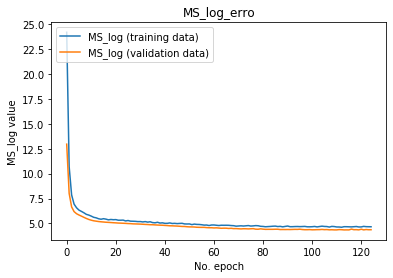

In [35]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MS_log (training data)')
plt.plot(history.history['val_loss'], label='MS_log (validation data)')
plt.title('MS_log_erro')
plt.ylabel('MS_log value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## trying with random forest

In [36]:
# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators=1, random_state=1)
# regressor.fit(X_train, y_train)

In [37]:
# y_pred = regressor.predict(X_test)

# from sklearn.metrics import r2_score
# r2_score(y_test, y_pred)

## prediction for test data

In [38]:
test_data = pd.read_csv('7342422066d511eb/dataset/test.csv')

In [39]:
test_data.isna().sum()

Customer Id                0
Artist Name                0
Artist Reputation        222
Height                   119
Width                    141
Weight                   149
Material                   0
Price Of Sculpture         0
Base Shipping Price        0
International              0
Express Shipment           0
Installation Included      0
Transport                232
Fragile                    0
Customer Information       0
Remote Location            0
Scheduled Date             0
Delivery Date              0
Customer Location          0
dtype: int64

In [40]:
test_data.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location
0,fffe3400310033003300,James Miller,0.35,53.0,18.0,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,07/03/17,07/06/17,"Santoshaven, IA 63481"
1,fffe3600350035003400,Karen Vetrano,0.67,7.0,4.0,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,05/02/16,05/02/16,"Ericksonton, OH 98253"
2,fffe3700360030003500,Roseanne Gaona,0.61,6.0,5.0,97.0,Aluminium,4.23,13.62,Yes,No,No,Airways,No,Working Class,No,01/04/18,01/06/18,APO AP 83453
3,fffe350038003600,Todd Almanza,0.14,15.0,8.0,757.0,Clay,6.28,23.79,No,Yes,No,Roadways,Yes,Wealthy,No,09/14/17,09/17/17,"Antonioborough, AL 54778"
4,fffe3500390032003500,Francis Rivero,0.63,10.0,4.0,1673.0,Marble,4.39,17.83,No,Yes,Yes,Roadways,No,Working Class,Yes,12/03/17,12/02/17,"Lake Frances, LA 03040"


## pre-processing of test data

In [41]:
test_ids = list(test_data['Customer Id'])

In [42]:
test_data['location']= [x[-8:-6] for x in test_data['Customer Location']]

In [43]:
#artist reputation, transport, 
test_data = test_data.fillna({'Artist Reputation': 0, 'Transport':'unknown'})

In [44]:
## fill nan weight
# test_data['Weight'] = test_data.apply(
#     lambda row: mean_weight[row['Material']] if pd.isna(row['Weight']) and not pd.isna(row['Material']) else row['Weight'],
#     axis=1
# )
test_data['Weight'].fillna((test_data['Weight'].median()), inplace=True)

In [45]:
test_data['area'] = test_data['Height']* test_data['Width']
test_data['area'] = test_data.apply(
    lambda row: row['Weight']/mean_density[row['Material']] if pd.isna(row['Width']) and not pd.isna(row['Material']) and not pd.isna(row['Weight']) else row['Width'],
    axis=1
)

In [46]:
test_data['delivery'] = [(datetime.strptime(test_data['Delivery Date'].iloc[x], '%m/%d/%y') - datetime.strptime(test_data['Scheduled Date'].iloc[x], '%m/%d/%y')).days for x in range(test_data.shape[0])]

In [47]:
test_data = test_data.drop(['Customer Id', 'Artist Name', 'Height', 'Width',
                           'Scheduled Date', 'Delivery Date',
                          'Customer Location'],axis = 1) 

In [48]:
test_data.rename(columns= {'Artist Reputation':'reputation',
                           'Price Of Sculpture': 'sculpture_price',
                          'Base Shipping Price':'shipping_price',
                          'Artist Name':'artist_name',
                          'Express Shipment':'express_shipment',
                          'Installation Included':'installation',
                             'Customer Information': 'customer_info',
                           'Remote Location': 'remote'
                         }, inplace=True)
test_data.head(10)

,reputation,Weight,Material,sculpture_price,shipping_price,International,express_shipment,installation,Transport,Fragile,customer_info,remote,location,area,delivery
0,0.35,871.0,Wood,5.98,19.11,Yes,Yes,No,Airways,No,Working Class,No,IA,18.0,3
1,0.67,108.0,Clay,6.92,13.96,No,No,No,Roadways,Yes,Working Class,No,OH,4.0,0
2,0.61,97.0,Aluminium,4.23,13.62,Yes,No,No,Airways,No,Working Class,No,AP,5.0,2
3,0.14,757.0,Clay,6.28,23.79,No,Yes,No,Roadways,Yes,Wealthy,No,AL,8.0,3
4,0.63,1673.0,Marble,4.39,17.83,No,Yes,Yes,Roadways,No,Working Class,Yes,LA,4.0,-1
5,0.34,1115.0,Clay,6.65,22.80,No,Yes,No,Airways,Yes,Wealthy,No,VT,6.0,4
6,0.00,2837.0,Clay,7.93,20.40,Yes,No,No,Waterways,Yes,Working Class,No,OK,13.0,-1
7,0.44,24250.0,Brass,121.61,44.10,Yes,Yes,Yes,Airways,No,Wealthy,No,UT,13.0,3
8,0.81,621.0,Wood,5.07,12.80,Yes,No,Yes,Waterways,No,Working Class,No,WI,10.0,-2
9,0.14,52.0,Wood,3.99,24.94,No,Yes,No,Roadways,No,Working Class,No,SC,4.0,-1


In [49]:
# artist = pd.get_dummies(test_data.artist_name, prefix='artist_name')
test_international = pd.get_dummies(test_data.express_shipment, prefix='International')
test_express = pd.get_dummies(test_data.express_shipment, prefix='express_shipment')
test_installation = pd.get_dummies(test_data.installation, prefix='installation')
test_transport = pd.get_dummies(test_data.Fragile, prefix='Transport')
test_fragile = pd.get_dummies(test_data.Fragile, prefix='Fragile')
test_customer_info = pd.get_dummies(test_data.customer_info, prefix='customer_info')
test_remote = pd.get_dummies(test_data.remote, prefix='remote')
test_location = pd.get_dummies(test_data.location, prefix='location')

In [50]:
X_pred = pd.concat([test_international, test_express, test_transport, test_fragile,  
                 test_data['area'],
                test_data['sculpture_price'], test_data['shipping_price'], test_data['delivery']] , axis=1)


In [51]:
# normalization
sc = StandardScaler()
X_pred = sc.fit_transform(X_pred)

In [52]:
# output_predictions = regressor.predict(X_pred)

In [53]:
output_predictions = model.predict(X_pred).tolist()
output_predictions = [x[0] for x in output_predictions]

In [54]:
submission = {}
submission['Customer Id'] = test_ids
submission['Cost'] = [x for x in output_predictions]

In [55]:
pd.DataFrame(submission).to_csv('submission030.csv', index=False)